In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import boxcox

#import dataset and store in variable "dataset". View the statistics overview of the dataset

dataset = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM457 Topics in business analytics/Final project/BEMM457 - Analysis on factors affecting high-school student performance and alcoholism/en_lpor_explorer.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   School                        649 non-null    object
 1   Gender                        649 non-null    object
 2   Age                           649 non-null    int64 
 3   Housing_Type                  649 non-null    object
 4   Family_Size                   649 non-null    object
 5   Parental_Status               649 non-null    object
 6   Mother_Education              643 non-null    object
 7   Father_Education              642 non-null    object
 8   Mother_Work                   649 non-null    object
 9   Father_Work                   649 non-null    object
 10  Reason_School_Choice          649 non-null    object
 11  Legal_Responsibility          649 non-null    object
 12  Commute_Time                  649 non-null    object
 13  Weekly_Study_Time   

In [399]:
#drop unused columns 

unused_columns = [
    "Age", "School", "Housing_Type", "Family_Size", "Mother_Work", "Father_Work",
    "Reason_School_Choice", "Legal_Responsibility", "Commute_Time", 
    "Attended_Daycare", "Has_Internet", "Free_Time_After_School", 
    "Time_with_Friends", "Is_Dating", "Health_Status"
]
dataset.drop(columns=unused_columns, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        649 non-null    object
 1   Parental_Status               649 non-null    object
 2   Mother_Education              643 non-null    object
 3   Father_Education              642 non-null    object
 4   Weekly_Study_Time             649 non-null    object
 5   Extra_Educational_Support     649 non-null    object
 6   Parental_Educational_Support  649 non-null    object
 7   Private_Tutoring              649 non-null    object
 8   Extracurricular_Activities    649 non-null    object
 9   Desire_Graduate_Education     649 non-null    object
 10  Good_Family_Relationship      649 non-null    object
 11  Alcohol_Weekdays              649 non-null    object
 12  Alcohol_Weekends              649 non-null    object
 13  School_Absence      

In [401]:
#Figure 8: Determine missing values in the dataset

print("Sum of dataset missing values: ")
dataset.isna().sum()

Sum of dataset missing values: 


Gender                          0
Parental_Status                 0
Mother_Education                6
Father_Education                7
Weekly_Study_Time               0
Extra_Educational_Support       0
Parental_Educational_Support    0
Private_Tutoring                0
Extracurricular_Activities      0
Desire_Graduate_Education       0
Good_Family_Relationship        0
Alcohol_Weekdays                0
Alcohol_Weekends                0
School_Absence                  0
Grade_1st_Semester              0
Grade_2nd_Semester              0
dtype: int64

In [403]:
#Figure 8: Determine whether the variables missing completely at random (MCAR)

def test_categorical_mcar(df, variables_with_missing):
    """
    Perform a chi-square test to evaluate whether missingness is MCAR for categorical data.
    Parameters:
        df (pd.DataFrame): The dataset with categorical data.
        variables_with_missing (list): List of variables with missing values to test.
    Returns:
        dict: Chi-square test results for each variable.
    """
    results = {}

    for var in variables_with_missing:
        df[f"{var}_missing"] = df[var].isnull().astype(int)

        for col in df.columns:
            if col != var and col != f"{var}_missing":
                contingency_table = pd.crosstab(df[f"{var}_missing"], df[col])
                
                chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table)
                
                results[var] = {
                    "Chi-Square Statistic": chi2_stat,
                    "P-Value": p_val,
                    "Degrees of Freedom": dof,
                    "Conclusion": "MCAR" if p_val > 0.05 else "Not MCAR"
                }

        df.drop(columns=[f"{var}_missing"], inplace=True)

    return results

categorical_columns_with_missing = ["Mother_Education", "Father_Education"]
mcar_results = test_categorical_mcar(dataset, categorical_columns_with_missing)

for var, result in mcar_results.items():
    print(f"Variable: {var}")
    print(f"  Chi-Square Statistic: {result['Chi-Square Statistic']:.4f}")
    print(f"  P-Value: {result['P-Value']:.4f}")
    print(f"  Degrees of Freedom: {result['Degrees of Freedom']}")
    print(f"  Conclusion: {result['Conclusion']}")
    print("-" * 35)

Variable: Mother_Education
  Chi-Square Statistic: 4.3068
  P-Value: 0.9965
  Degrees of Freedom: 15
  Conclusion: MCAR
-----------------------------------
Variable: Father_Education
  Chi-Square Statistic: 9.3203
  P-Value: 0.8602
  Degrees of Freedom: 15
  Conclusion: MCAR
-----------------------------------


In [405]:
#Since the missing values are proved to be MCAR, drop the rows containing N/A accordingly

dataset.dropna(inplace = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 0 to 648
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        637 non-null    object
 1   Parental_Status               637 non-null    object
 2   Mother_Education              637 non-null    object
 3   Father_Education              637 non-null    object
 4   Weekly_Study_Time             637 non-null    object
 5   Extra_Educational_Support     637 non-null    object
 6   Parental_Educational_Support  637 non-null    object
 7   Private_Tutoring              637 non-null    object
 8   Extracurricular_Activities    637 non-null    object
 9   Desire_Graduate_Education     637 non-null    object
 10  Good_Family_Relationship      637 non-null    object
 11  Alcohol_Weekdays              637 non-null    object
 12  Alcohol_Weekends              637 non-null    object
 13  School_Absence           

In [407]:
#Figure 9: School absence column outlier removal
#drop 2 rows that average grade is identified as outlier

print(dataset["School_Absence"].describe())
to_be_removed_rows = dataset[dataset["School_Absence"] >= 26]
print("The school_absence values to be removed are " + str(to_be_removed_rows["School_Absence"].unique()))

dataset = dataset[dataset["School_Absence"] < 26]

print(dataset["School_Absence"].describe())

count    637.000000
mean       3.704867
std        4.664282
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       32.000000
Name: School_Absence, dtype: float64
The school_absence values to be removed are [32 30 26]
count    634.000000
mean       3.583596
std        4.324527
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       24.000000
Name: School_Absence, dtype: float64


In [409]:
#standardize categorical columns to lowercase and strip whitespace for easy data transformation

categorical_columns = dataset.select_dtypes(include=["object", "category"]).columns
numerical_columns = dataset.select_dtypes(include=["int64", "float64"]).columns

for column in categorical_columns :
    dataset[column] = dataset[column].str.lower().str.strip()
dataset.head()

,Gender,Parental_Status,Mother_Education,Father_Education,Weekly_Study_Time,Extra_Educational_Support,Parental_Educational_Support,Private_Tutoring,Extracurricular_Activities,Desire_Graduate_Education,Good_Family_Relationship,Alcohol_Weekdays,Alcohol_Weekends,School_Absence,Grade_1st_Semester,Grade_2nd_Semester
0,female,separated,higher education,higher education,2 to 5h,yes,no,no,no,yes,good,very low,very low,4,0,11
1,female,living together,primary school,primary school,2 to 5h,no,yes,no,no,yes,excellent,very low,very low,2,9,11
2,female,living together,primary school,primary school,2 to 5h,yes,no,no,no,yes,good,low,moderate,6,12,13
3,female,living together,higher education,lower secondary school,5 to 10h,no,yes,no,yes,yes,fair,very low,very low,0,14,14
4,female,living together,high school,high school,2 to 5h,no,yes,no,no,yes,good,very low,low,0,11,13


In [411]:
#create average grade column and drop old grade columns

dataset["Average_Grade"] = dataset[["Grade_1st_Semester", "Grade_2nd_Semester"]].mean(axis=1)
dataset.drop(labels=["Grade_1st_Semester", "Grade_2nd_Semester"], axis=1, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 0 to 648
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        634 non-null    object 
 1   Parental_Status               634 non-null    object 
 2   Mother_Education              634 non-null    object 
 3   Father_Education              634 non-null    object 
 4   Weekly_Study_Time             634 non-null    object 
 5   Extra_Educational_Support     634 non-null    object 
 6   Parental_Educational_Support  634 non-null    object 
 7   Private_Tutoring              634 non-null    object 
 8   Extracurricular_Activities    634 non-null    object 
 9   Desire_Graduate_Education     634 non-null    object 
 10  Good_Family_Relationship      634 non-null    object 
 11  Alcohol_Weekdays              634 non-null    object 
 12  Alcohol_Weekends              634 non-null    object 
 13  School_Abs

In [413]:
#Figure 10: Binary Transformation of Average Grade Column
#convert average grade to pass (1)/failed (0)

dataset["Pass_Fail"] = (dataset["Average_Grade"] >= 10).astype(int)

dataset[["Average_Grade", "Pass_Fail"]].head()

,Average_Grade,Pass_Fail
0,5.5,0
1,10.0,1
2,12.5,1
3,14.0,1
4,12.0,1


In [415]:
#Determine numerical columns and categorical columns

categorical_columns = dataset.select_dtypes(include=["object", "category"]).columns
numerical_columns = dataset.select_dtypes(include=["int64", "float64"]).columns

print(numerical_columns)
print(categorical_columns)

Index(['School_Absence', 'Average_Grade', 'Pass_Fail'], dtype='object')
Index(['Gender', 'Parental_Status', 'Mother_Education', 'Father_Education',
       'Weekly_Study_Time', 'Extra_Educational_Support',
       'Parental_Educational_Support', 'Private_Tutoring',
       'Extracurricular_Activities', 'Desire_Graduate_Education',
       'Good_Family_Relationship', 'Alcohol_Weekdays', 'Alcohol_Weekends'],
      dtype='object')


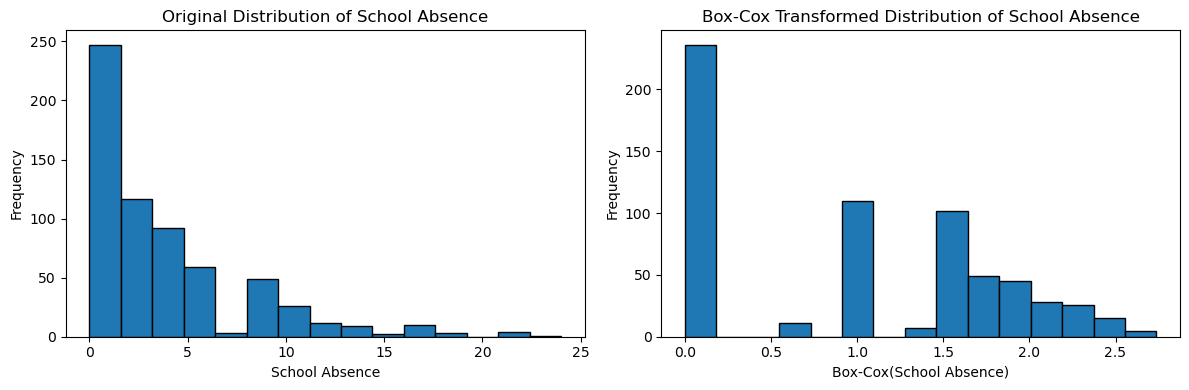

In [417]:
#Figure 11: Box-cox transformation of school absence column

dataset["School_Absence_To_Transform"] = dataset["School_Absence"] + 1
dataset["School_Absence_BoxCox"], _ = boxcox(dataset["School_Absence_To_Transform"])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(dataset['School_Absence'], bins=15, edgecolor='black')
plt.title("Original Distribution of School Absence")
plt.xlabel("School Absence")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(dataset['School_Absence_BoxCox'], bins=15, edgecolor='black')
plt.title("Box-Cox Transformed Distribution of School Absence")
plt.xlabel("Box-Cox(School Absence)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [419]:
#drop the old school_absence column and retain only log-transformed for further analysis
dataset = dataset.drop(columns=["School_Absence", "School_Absence_To_Transform"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 0 to 648
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        634 non-null    object 
 1   Parental_Status               634 non-null    object 
 2   Mother_Education              634 non-null    object 
 3   Father_Education              634 non-null    object 
 4   Weekly_Study_Time             634 non-null    object 
 5   Extra_Educational_Support     634 non-null    object 
 6   Parental_Educational_Support  634 non-null    object 
 7   Private_Tutoring              634 non-null    object 
 8   Extracurricular_Activities    634 non-null    object 
 9   Desire_Graduate_Education     634 non-null    object 
 10  Good_Family_Relationship      634 non-null    object 
 11  Alcohol_Weekdays              634 non-null    object 
 12  Alcohol_Weekends              634 non-null    object 
 13  Average_Gr

In [421]:
#look for unique values for each ordinal columnn

unique_values = {}

for col in categorical_columns:
    if col in dataset.columns:  # Check if the column exists in the dataset
        unique_values[col] = dataset[col].unique() 

unique_values

{'Gender': array(['female', 'male'], dtype=object),
 'Parental_Status': array(['separated', 'living together'], dtype=object),
 'Mother_Education': array(['higher education', 'primary school', 'high school',
        'lower secondary school'], dtype=object),
 'Father_Education': array(['higher education', 'primary school', 'lower secondary school',
        'high school'], dtype=object),
 'Weekly_Study_Time': array(['2 to 5h', '5 to 10h', 'up to 2h', 'more than 10h'], dtype=object),
 'Extra_Educational_Support': array(['yes', 'no'], dtype=object),
 'Parental_Educational_Support': array(['no', 'yes'], dtype=object),
 'Private_Tutoring': array(['no', 'yes'], dtype=object),
 'Extracurricular_Activities': array(['no', 'yes'], dtype=object),
 'Desire_Graduate_Education': array(['yes', 'no'], dtype=object),
 'Good_Family_Relationship': array(['good', 'excellent', 'fair', 'very poor', 'poor'], dtype=object),
 'Alcohol_Weekdays': array(['very low', 'low', 'very high', 'moderate', 'high'], dtype=

In [423]:
#Transforming yes/no columns using binary mapping 

yes_no_columns = ["Extra_Educational_Support", "Parental_Educational_Support", 
                  "Private_Tutoring", "Extracurricular_Activities", "Desire_Graduate_Education"]

for items in yes_no_columns :
    dataset[items] = dataset[items].map({"yes" : 1, "no" : 0})

dataset.head()

,Gender,Parental_Status,Mother_Education,Father_Education,Weekly_Study_Time,Extra_Educational_Support,Parental_Educational_Support,Private_Tutoring,Extracurricular_Activities,Desire_Graduate_Education,Good_Family_Relationship,Alcohol_Weekdays,Alcohol_Weekends,Average_Grade,Pass_Fail,School_Absence_BoxCox
0,female,separated,higher education,higher education,2 to 5h,1,0,0,0,1,good,very low,very low,5.5,0,1.482447
1,female,living together,primary school,primary school,2 to 5h,0,1,0,0,1,excellent,very low,very low,10.0,1,1.038412
2,female,living together,primary school,primary school,2 to 5h,1,0,0,0,1,good,low,moderate,12.5,1,1.762350
3,female,living together,higher education,lower secondary school,5 to 10h,0,1,0,1,1,fair,very low,very low,14.0,1,0.000000
4,female,living together,high school,high school,2 to 5h,0,1,0,0,1,good,very low,low,12.0,1,0.000000


In [425]:
#Transform ordinal columns, convert them into numerical scale
#start from 1 as the variables provide scaling progressions

ordinal_columns = ["Alcohol_Weekdays", "Alcohol_Weekends", "Time_with_Friends", "Good_Family_Relationship",
    "Weekly_Study_Time", "Mother_Education", "Father_Education"]

ordinal_mappings = {
    "very low": 1, "low": 2, "moderate": 3, "high": 4, "very high": 5,
    "very poor": 1, "poor": 2, "fair": 3, "good": 4, "very good": 5, "excellent": 5,
    "up to 2h": 1, "2 to 5h": 2, "5 to 10h": 3, "more than 10h": 4,
    "none": 1, "primary school": 2, "lower secondary school": 3, "high school": 4, "higher education": 5,
    "up to 3": 1, "above 3": 2,
    "up to 15 min": 1, "15 to 30 min": 2, "30 min to 1h": 3, "more than 1h": 4
}

for col in ordinal_columns:
    if col in dataset.columns:
        dataset[col] = dataset[col].astype(str).str.lower().str.strip().map(ordinal_mappings)

dataset.head()

,Gender,Parental_Status,Mother_Education,Father_Education,Weekly_Study_Time,Extra_Educational_Support,Parental_Educational_Support,Private_Tutoring,Extracurricular_Activities,Desire_Graduate_Education,Good_Family_Relationship,Alcohol_Weekdays,Alcohol_Weekends,Average_Grade,Pass_Fail,School_Absence_BoxCox
0,female,separated,5,5,2,1,0,0,0,1,4,1,1,5.5,0,1.482447
1,female,living together,2,2,2,0,1,0,0,1,5,1,1,10.0,1,1.038412
2,female,living together,2,2,2,1,0,0,0,1,4,2,3,12.5,1,1.762350
3,female,living together,5,3,3,0,1,0,1,1,3,1,1,14.0,1,0.000000
4,female,living together,4,4,2,0,1,0,0,1,4,1,2,12.0,1,0.000000


In [427]:
#Transform nominal variables by mapping
#start mapping with 0 as these are nominal variables that have no inherent order

remaining_categorical_columns = list(set(categorical_columns) - set(ordinal_columns) - set(yes_no_columns))
print(remaining_categorical_columns)

remaining_mappings = {
    "female": 0, "male": 1,
    "living together": 0, "separated": 1
}

for col in remaining_categorical_columns :
    if col in dataset.columns :
        dataset[col] = dataset[col].astype(str).str.lower().str.strip().map(remaining_mappings)

dataset.head()

['Gender', 'Parental_Status']


,Gender,Parental_Status,Mother_Education,Father_Education,Weekly_Study_Time,Extra_Educational_Support,Parental_Educational_Support,Private_Tutoring,Extracurricular_Activities,Desire_Graduate_Education,Good_Family_Relationship,Alcohol_Weekdays,Alcohol_Weekends,Average_Grade,Pass_Fail,School_Absence_BoxCox
0,0,1,5,5,2,1,0,0,0,1,4,1,1,5.5,0,1.482447
1,0,0,2,2,2,0,1,0,0,1,5,1,1,10.0,1,1.038412
2,0,0,2,2,2,1,0,0,0,1,4,2,3,12.5,1,1.762350
3,0,0,5,3,3,0,1,0,1,1,3,1,1,14.0,1,0.000000
4,0,0,4,4,2,0,1,0,0,1,4,1,2,12.0,1,0.000000


In [429]:
#save the file as a new file to conduct further analysis

dataset.to_csv("cleaned_dataset.csv")